<a href="https://colab.research.google.com/github/ConanOReilly/Final_Year_Project/blob/main/Image_Data/DenseNet121FineTuning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Fine-Tuning DenseNet121**
DenseNet121, after model comparison, was the model that generalised the best when classifying all skin lesions.

Processes involved in fine-tuning:


*   Progressive Unfreezing
*   Ensemble freeze phases
*   Applied learning Rate Scheduling
*   Implement Focal Loss

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# **Libraries**

In [ ]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torchvision import models, transforms
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.utils.class_weight import compute_class_weight
from tqdm import tqdm
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

In [ ]:
image_dir = "/content/drive/MyDrive/Final Year Project/Code/MetaBlock/Data/imgs"
metadata_path = "/content/drive/MyDrive/Final Year Project/Data/PAD/Metadata/metadata.csv"

metadata_df = pd.read_csv(metadata_path)
metadata_df["diagnostic"] = metadata_df["diagnostic"].str.upper()

label_encoder = LabelEncoder()
metadata_df["label_encoded"] = label_encoder.fit_transform(metadata_df["diagnostic"])
class_names = label_encoder.classes_
num_classes = len(class_names)

# **Image Pre-processing and Defining Classes**

In [ ]:
img_size = 224

train_transforms = transforms.Compose([
    transforms.Resize((img_size, img_size)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(20),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

val_transforms = transforms.Compose([
    transforms.Resize((img_size, img_size)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

In [ ]:
class SkinCancerDataset(Dataset):
    def __init__(self, df, image_dir, transform=None):
        self.df = df
        self.image_dir = image_dir
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        img_path = os.path.join(self.image_dir, row["img_id"])
        label = row["label_encoded"]

        try:
            image = Image.open(img_path).convert("RGB")
        except Exception as e:
            print(f"Error loading image: {img_path} | {e}")
            return self.__getitem__((idx + 1) % len(self.df))

        if self.transform:
            image = self.transform(image)

        return image, label

In [ ]:
train_df, val_df = train_test_split(metadata_df, test_size=0.2, stratify=metadata_df["label_encoded"], random_state=42)

train_dataset = SkinCancerDataset(train_df, image_dir, transform=train_transforms)
val_dataset = SkinCancerDataset(val_df, image_dir, transform=val_transforms)

batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=2)

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = models.densenet121(pretrained=True)
model.classifier = nn.Linear(model.classifier.in_features, num_classes)
model = model.to(device)

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DenseNet121_Weights.IMAGENET1K_V1`. You can also use `weights=DenseNet121_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/densenet121-a639ec97.pth" to /root/.cache/torch/hub/checkpoints/densenet121-a639ec97.pth
100%|██████████| 30.8M/30.8M [00:00<00:00, 111MB/s] 


In [ ]:
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(metadata_df["label_encoded"]),
    y=metadata_df["label_encoded"]
)
class_weights_tensor = torch.tensor(class_weights, dtype=torch.float).to(device)
criterion = nn.CrossEntropyLoss(weight=class_weights_tensor)

# **Training and Evaluation**

In [ ]:
def train(model, loader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    correct, total = 0, 0

    for inputs, labels in tqdm(loader, desc="Training", leave=False):
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * inputs.size(0)
        _, predicted = outputs.max(1)
        correct += (predicted == labels).sum().item()
        total += labels.size(0)

    return running_loss / total, correct / total

In [ ]:
def evaluate(model, loader, criterion, device):
    model.eval()
    running_loss = 0.0
    correct, total = 0, 0

    with torch.no_grad():
        for inputs, labels in tqdm(loader, desc="Validation", leave=False):
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            running_loss += loss.item() * inputs.size(0)
            _, predicted = outputs.max(1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)

    return running_loss / total, correct / total

# **Progressive Unfreezing**

In [ ]:
def freeze_all_but_classifier(model):
    for param in model.features.parameters():
        param.requires_grad = False
    for param in model.classifier.parameters():
        param.requires_grad = True

def unfreeze_layers(model, layer_keywords):
    for name, param in model.named_parameters():
        if any(keyword in name for keyword in layer_keywords):
            param.requires_grad = True

def get_trainable_params(model):
    return [p for p in model.parameters() if p.requires_grad]

def run_fine_tuning_phase(model, train_loader, val_loader, criterion, device,
                          layer_keywords, lr, num_epochs, phase_name, save_dir):

    print(f"\n Starting Phase: {phase_name}")
    unfreeze_layers(model, layer_keywords)

    optimizer = torch.optim.AdamW(get_trainable_params(model), lr=lr, weight_decay=1e-4)
    best_val_acc = 0.0
    save_path = os.path.join(save_dir, f"densenet121_{phase_name}.pth")

    history = {
        "train_loss": [],
        "train_acc": [],
        "val_loss": [],
        "val_acc": []
    }

    for epoch in range(num_epochs):
        train_loss, train_acc = train(model, train_loader, criterion, optimizer, device)
        val_loss, val_acc = evaluate(model, val_loader, criterion, device)

        print(f"Epoch {epoch+1}/{num_epochs} - Train Acc: {train_acc:.4f} | Val Acc: {val_acc:.4f}")

        history["train_loss"].append(train_loss)
        history["train_acc"].append(train_acc)
        history["val_loss"].append(val_loss)
        history["val_acc"].append(val_acc)

        if val_acc > best_val_acc:
            best_val_acc = val_acc
            torch.save(model.state_dict(), save_path)
            print(f"Saved best model for phase '{phase_name}' at {save_path}")

    return save_path, history

In [ ]:
def run_training(model, train_loader, val_loader, criterion, optimizer, device,
                 num_epochs=10, save_path="best_model.pth"):

    best_val_acc = 0.0

    for epoch in range(num_epochs):
        train_loss, train_acc = train(model, train_loader, criterion, optimizer, device)
        val_loss, val_acc = evaluate(model, val_loader, criterion, device)

        print(f"Epoch {epoch+1}/{num_epochs}")
        print(f"Train Loss: {train_loss:.4f}, Accuracy: {train_acc:.4f}")
        print(f"Val   Loss: {val_loss:.4f}, Accuracy: {val_acc:.4f}")

        # Save the best model
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            torch.save(model.state_dict(), save_path)
            print(f"Saved new best model to: {save_path}")

In [ ]:
def evaluate_model(model, dataloader, class_names, device):
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for images, labels in dataloader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            preds = torch.argmax(outputs, dim=1)

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    print("Classification Report:\n", classification_report(all_labels, all_preds, target_names=class_names))

    cm = confusion_matrix(all_labels, all_preds)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
    disp.plot(xticks_rotation=45)
    plt.tight_layout()
    plt.show()

In [ ]:
def plot_training_curves(history, phase_name):
    epochs = range(1, len(history["train_loss"]) + 1)

    plt.figure(figsize=(12, 5))

    # Accuracy
    plt.subplot(1, 2, 1)
    plt.plot(epochs, history["train_acc"], label="Train Acc")
    plt.plot(epochs, history["val_acc"], label="Val Acc")
    plt.title(f"{phase_name} - Accuracy")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.legend()
    plt.grid(True)

    # Loss
    plt.subplot(1, 2, 2)
    plt.plot(epochs, history["train_loss"], label="Train Loss")
    plt.plot(epochs, history["val_loss"], label="Val Loss")
    plt.title(f"{phase_name} - Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()

In [ ]:
save_dir = "/content/drive/MyDrive/Final Year Project/Code/Image Classification/DenseNet121"
os.makedirs(save_dir, exist_ok=True)


 Starting Phase: phase1_classifier


Epoch 1/5 - Train Acc: 0.5005 | Val Acc: 0.4109
Saved best model for phase 'phase1_classifier' at /content/drive/MyDrive/Final Year Project/Code/Image Classification/DenseNet121/densenet121_phase1_classifier.pth


Epoch 2/5 - Train Acc: 0.5169 | Val Acc: 0.5087
Saved best model for phase 'phase1_classifier' at /content/drive/MyDrive/Final Year Project/Code/Image Classification/DenseNet121/densenet121_phase1_classifier.pth


Epoch 3/5 - Train Acc: 0.5555 | Val Acc: 0.5587
Saved best model for phase 'phase1_classifier' at /content/drive/MyDrive/Final Year Project/Code/Image Classification/DenseNet121/densenet121_phase1_classifier.pth


Epoch 4/5 - Train Acc: 0.5528 | Val Acc: 0.4913


Epoch 5/5 - Train Acc: 0.5550 | Val Acc: 0.5087


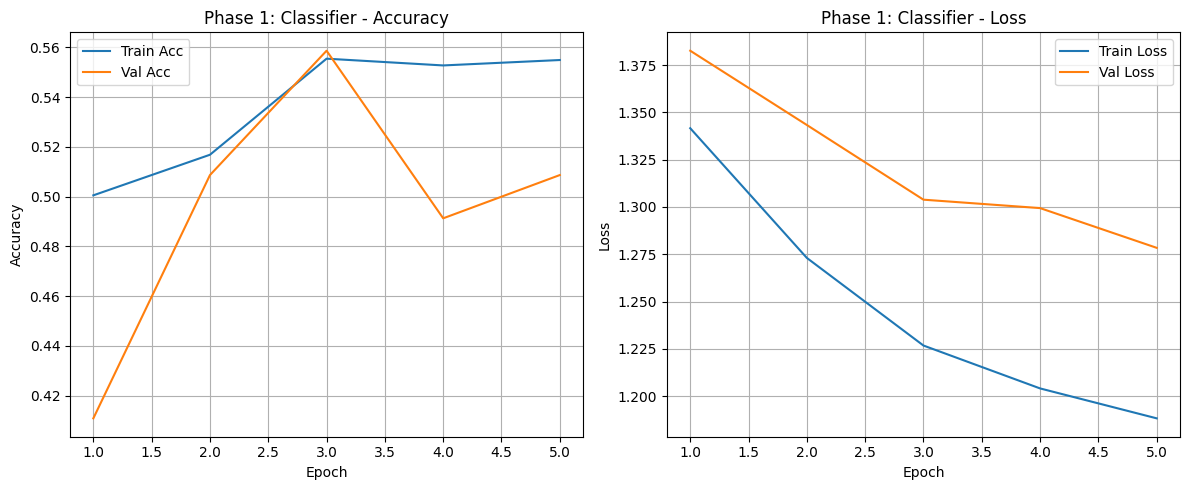

In [ ]:
# Phase 1 – Freeze backbone, train classifier only
freeze_all_but_classifier(model)
path1, history1 = run_fine_tuning_phase(model, train_loader, val_loader, criterion, device,
                                        layer_keywords=["classifier"],
                                        lr=3e-4, num_epochs=5,
                                        phase_name="phase1_classifier", save_dir=save_dir)
plot_training_curves(history1, "Phase 1: Classifier")

In [ ]:
model.load_state_dict(torch.load(path1))
model.to(device)
model.eval()

DenseNet(
  (features): Sequential(
    (conv0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu0): ReLU(inplace=True)
    (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (denseblock1): _DenseBlock(
      (denselayer1): _DenseLayer(
        (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace=True)
        (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu2): ReLU(inplace=True)
        (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (denselayer2): _DenseLayer(
        (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu

Classification Report:
               precision    recall  f1-score   support

         ACK       0.74      0.45      0.56       146
         BCC       0.62      0.74      0.68       169
         MEL       0.38      0.60      0.46        10
         NEV       0.64      0.61      0.62        49
         SCC       0.19      0.15      0.17        39
         SEK       0.32      0.51      0.39        47

    accuracy                           0.56       460
   macro avg       0.48      0.51      0.48       460
weighted avg       0.59      0.56      0.56       460



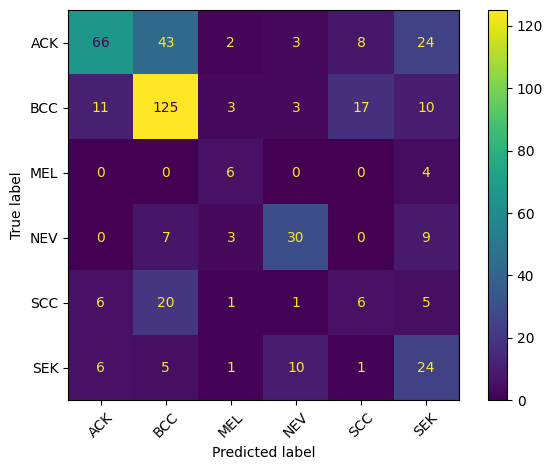

In [ ]:
evaluate_model(model, val_loader, class_names, device)


 Starting Phase: phase2_block4


Epoch 1/5 - Train Acc: 0.5522 | Val Acc: 0.5630
Saved best model for phase 'phase2_block4' at /content/drive/MyDrive/Final Year Project/Code/Image Classification/DenseNet121/densenet121_phase2_block4.pth


Epoch 2/5 - Train Acc: 0.6338 | Val Acc: 0.5674
Saved best model for phase 'phase2_block4' at /content/drive/MyDrive/Final Year Project/Code/Image Classification/DenseNet121/densenet121_phase2_block4.pth


Epoch 3/5 - Train Acc: 0.6659 | Val Acc: 0.6043
Saved best model for phase 'phase2_block4' at /content/drive/MyDrive/Final Year Project/Code/Image Classification/DenseNet121/densenet121_phase2_block4.pth


Epoch 4/5 - Train Acc: 0.6812 | Val Acc: 0.6174
Saved best model for phase 'phase2_block4' at /content/drive/MyDrive/Final Year Project/Code/Image Classification/DenseNet121/densenet121_phase2_block4.pth


Epoch 5/5 - Train Acc: 0.7231 | Val Acc: 0.6239
Saved best model for phase 'phase2_block4' at /content/drive/MyDrive/Final Year Project/Code/Image Classification/DenseNet121/densenet121_phase2_block4.pth


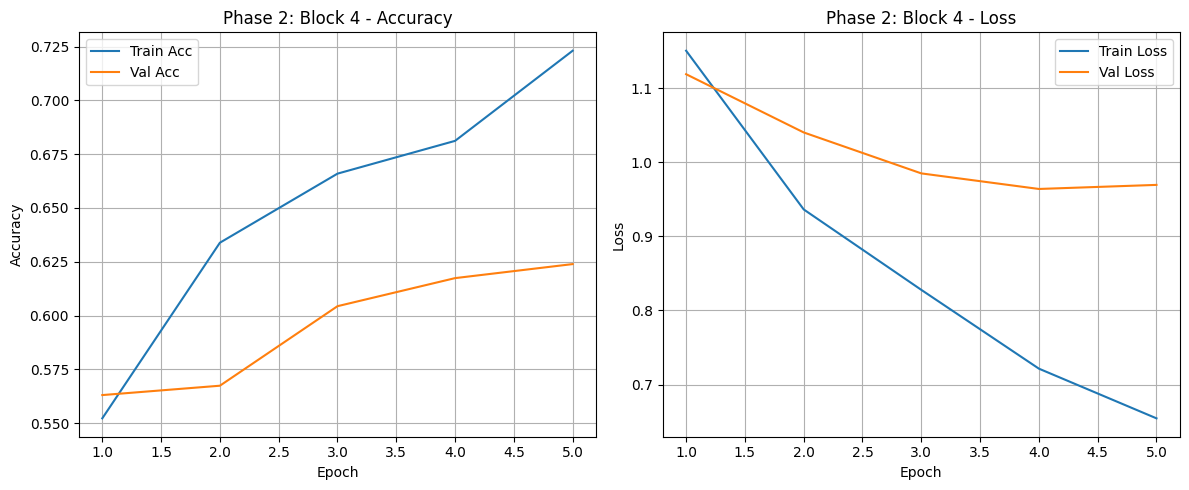

In [ ]:
# Phase 2 – Unfreeze denseblock4 + norm5
model.load_state_dict(torch.load(path1))
path2, history2 = run_fine_tuning_phase(model, train_loader, val_loader, criterion, device,
                                        layer_keywords=["denseblock4", "norm5"],
                                        lr=1e-4, num_epochs=5,
                                        phase_name="phase2_block4", save_dir=save_dir)
plot_training_curves(history2, "Phase 2: Block 4")

In [ ]:
model.load_state_dict(torch.load(path2))

<All keys matched successfully>

Classification Report:
               precision    recall  f1-score   support

         ACK       0.78      0.62      0.69       146
         BCC       0.73      0.70      0.72       169
         MEL       0.53      0.90      0.67        10
         NEV       0.49      0.65      0.56        49
         SCC       0.31      0.51      0.39        39
         SEK       0.47      0.36      0.41        47

    accuracy                           0.62       460
   macro avg       0.55      0.62      0.57       460
weighted avg       0.65      0.62      0.63       460



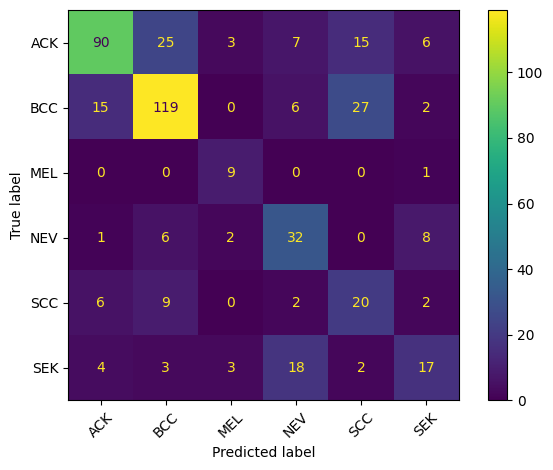

In [ ]:
evaluate_model(model, val_loader, class_names, device)


 Starting Phase: phase3_block3


Epoch 1/5 - Train Acc: 0.7519 | Val Acc: 0.6478
Saved best model for phase 'phase3_block3' at /content/drive/MyDrive/Final Year Project/Code/Image Classification/DenseNet121/densenet121_phase3_block3.pth


Epoch 2/5 - Train Acc: 0.7845 | Val Acc: 0.6630
Saved best model for phase 'phase3_block3' at /content/drive/MyDrive/Final Year Project/Code/Image Classification/DenseNet121/densenet121_phase3_block3.pth


Epoch 3/5 - Train Acc: 0.8156 | Val Acc: 0.6848
Saved best model for phase 'phase3_block3' at /content/drive/MyDrive/Final Year Project/Code/Image Classification/DenseNet121/densenet121_phase3_block3.pth


Epoch 4/5 - Train Acc: 0.8395 | Val Acc: 0.6543


Epoch 5/5 - Train Acc: 0.8624 | Val Acc: 0.6630


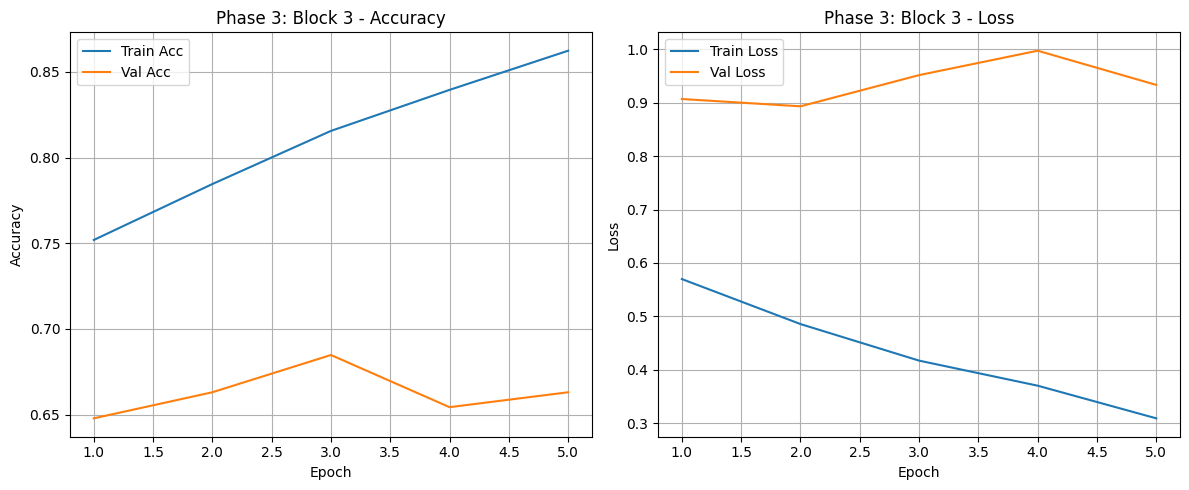

In [ ]:
# Phase 3 – Unfreeze denseblock3 + transition3
model.load_state_dict(torch.load(path2))
path3, history3 = run_fine_tuning_phase(model, train_loader, val_loader, criterion, device,
                                        layer_keywords=["denseblock3", "transition3"],
                                        lr=5e-5, num_epochs=5,
                                        phase_name="phase3_block3", save_dir=save_dir)
plot_training_curves(history3, "Phase 3: Block 3")

In [ ]:
model.load_state_dict(torch.load(path3))

<All keys matched successfully>

Classification Report:
               precision    recall  f1-score   support

         ACK       0.73      0.77      0.75       146
         BCC       0.77      0.67      0.72       169
         MEL       1.00      0.60      0.75        10
         NEV       0.58      0.82      0.68        49
         SCC       0.41      0.49      0.45        39
         SEK       0.64      0.53      0.58        47

    accuracy                           0.68       460
   macro avg       0.69      0.65      0.65       460
weighted avg       0.70      0.68      0.69       460



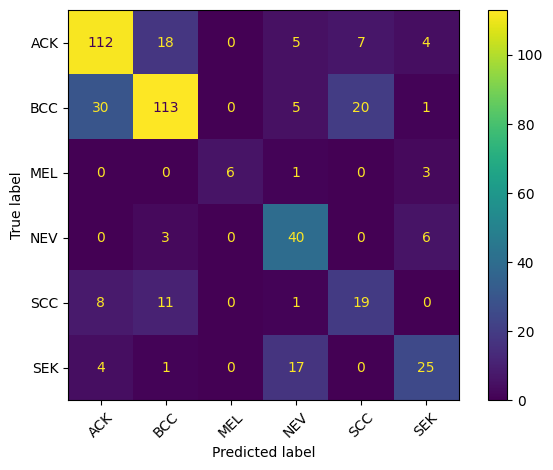

In [ ]:
evaluate_model(model, val_loader, class_names, device)

In [ ]:
path3 = "/content/drive/MyDrive/Final Year Project/Code/Image Classification/DenseNet121/densenet121_phase3_block3.pth"

In [ ]:
model = models.densenet121(pretrained=False)
model.classifier = nn.Linear(model.classifier.in_features, num_classes)
model.load_state_dict(torch.load(path3))
model.to(device)
model.eval()

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


DenseNet(
  (features): Sequential(
    (conv0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu0): ReLU(inplace=True)
    (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (denseblock1): _DenseBlock(
      (denselayer1): _DenseLayer(
        (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace=True)
        (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu2): ReLU(inplace=True)
        (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (denselayer2): _DenseLayer(
        (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu


 Starting Phase: phase4_all


Epoch 1/5 - Train Acc: 0.8406 | Val Acc: 0.6500
Saved best model for phase 'phase4_all' at /content/drive/MyDrive/Final Year Project/Code/Image Classification/DenseNet121/densenet121_phase4_all.pth


Epoch 2/5 - Train Acc: 0.8553 | Val Acc: 0.7000
Saved best model for phase 'phase4_all' at /content/drive/MyDrive/Final Year Project/Code/Image Classification/DenseNet121/densenet121_phase4_all.pth


Epoch 3/5 - Train Acc: 0.8705 | Val Acc: 0.6804


Epoch 4/5 - Train Acc: 0.8743 | Val Acc: 0.6935


Epoch 5/5 - Train Acc: 0.8808 | Val Acc: 0.6674


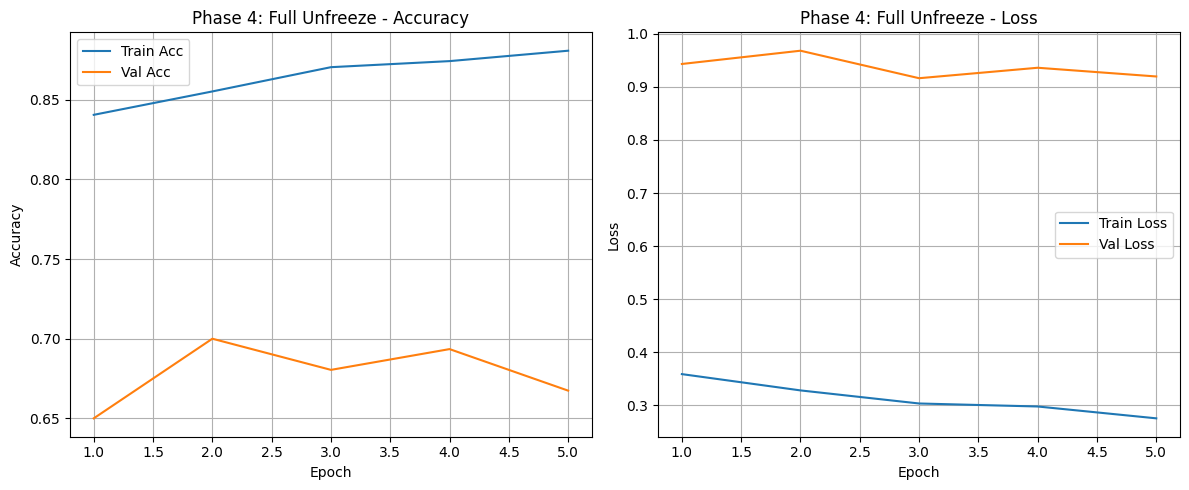

In [ ]:
# Full unfreeze
model.load_state_dict(torch.load(path3))
path4, history4 = run_fine_tuning_phase(model, train_loader, val_loader, criterion, device,
                                        layer_keywords=[""],
                                        lr=1e-5, num_epochs=5,
                                        phase_name="phase4_all", save_dir=save_dir)
plot_training_curves(history4, "Phase 4: Full Unfreeze")

Classification Report:
               precision    recall  f1-score   support

         ACK       0.76      0.74      0.75       146
         BCC       0.79      0.66      0.72       169
         MEL       0.75      0.60      0.67        10
         NEV       0.55      0.76      0.64        49
         SCC       0.34      0.56      0.42        39
         SEK       0.61      0.49      0.54        47

    accuracy                           0.67       460
   macro avg       0.63      0.63      0.62       460
weighted avg       0.70      0.67      0.68       460



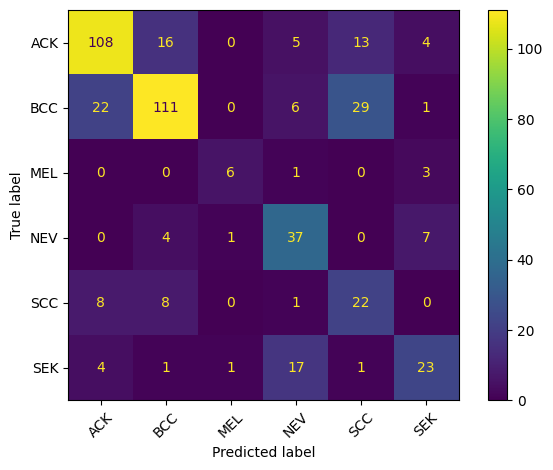

In [ ]:
evaluate_model(model, val_loader, class_names, device)

# **Ensemble Phase 3 and 4**

In [ ]:
path3 = "/content/drive/MyDrive/Final Year Project/Code/Image Classification/DenseNet121/densenet121_phase3_block3.pth"
path4 = "/content/drive/MyDrive/Final Year Project/Code/Image Classification/DenseNet121/densenet121_phase4_all.pth"

In [ ]:
model_phase3 = models.densenet121(pretrained=False)
model_phase3.classifier = nn.Linear(model_phase3.classifier.in_features, num_classes)
model_phase3.load_state_dict(torch.load(path3))
model_phase3.to(device)
model_phase3.eval()

model_phase4 = models.densenet121(pretrained=False)
model_phase4.classifier = nn.Linear(model_phase4.classifier.in_features, num_classes)
model_phase4.load_state_dict(torch.load(path4))
model_phase4.to(device)
model_phase4.eval()

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


DenseNet(
  (features): Sequential(
    (conv0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu0): ReLU(inplace=True)
    (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (denseblock1): _DenseBlock(
      (denselayer1): _DenseLayer(
        (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace=True)
        (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu2): ReLU(inplace=True)
        (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (denselayer2): _DenseLayer(
        (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu

In [ ]:
def evaluate_ensemble(model1, model2, dataloader, class_names, device):
    all_preds = []
    all_labels = []

    model1.eval()
    model2.eval()

    with torch.no_grad():
        for images, labels in dataloader:
            images, labels = images.to(device), labels.to(device)

            outputs1 = model1(images)
            outputs2 = model2(images)

            # Get softmax probabilities
            probs1 = F.softmax(outputs1, dim=1)
            probs2 = F.softmax(outputs2, dim=1)

            # Average predictions
            avg_probs = (probs1 + probs2) / 2
            preds = torch.argmax(avg_probs, dim=1)

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    print("Ensemble Classification Report:\n")
    print(classification_report(all_labels, all_preds, target_names=class_names))

    cm = confusion_matrix(all_labels, all_preds)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
    disp.plot(xticks_rotation=45)
    plt.tight_layout()
    plt.show()

Ensemble Classification Report:

              precision    recall  f1-score   support

         ACK       0.72      0.77      0.75       146
         BCC       0.79      0.68      0.73       169
         MEL       1.00      0.60      0.75        10
         NEV       0.58      0.82      0.68        49
         SCC       0.43      0.51      0.47        39
         SEK       0.63      0.51      0.56        47

    accuracy                           0.69       460
   macro avg       0.69      0.65      0.66       460
weighted avg       0.71      0.69      0.69       460



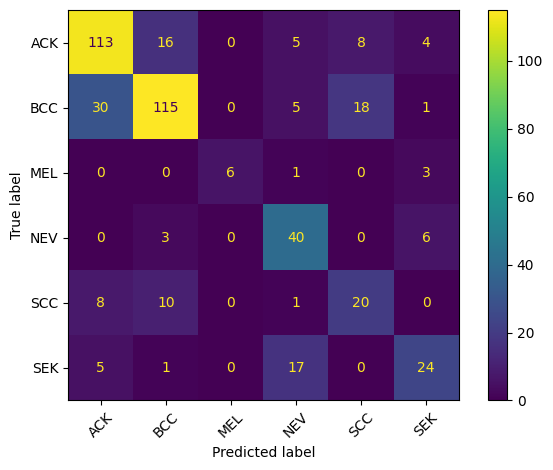

In [ ]:
evaluate_ensemble(model_phase3, model_phase4, val_loader, class_names, device)

**Ensembling Phase 3 and 4**

In [ ]:
dir_path = "/content/drive/MyDrive/Final Year Project/Code/Image Classification/DenseNet121"
file_path = os.path.join(dir_path, "densenet_ensemble_phase_3&4.py")

ensemble_code = """
class DenseNetEnsemble(nn.Module):
    def __init__(self, path_model_1, path_model_2, num_classes, device):
        super(DenseNetEnsemble, self).__init__()
        self.model1 = models.densenet121(pretrained=False)
        self.model1.classifier = nn.Linear(self.model1.classifier.in_features, num_classes)
        self.model1.load_state_dict(torch.load(path_model_1, map_location=device))
        self.model1.to(device)
        self.model1.eval()

        self.model2 = models.densenet121(pretrained=False)
        self.model2.classifier = nn.Linear(self.model2.classifier.in_features, num_classes)
        self.model2.load_state_dict(torch.load(path_model_2, map_location=device))
        self.model2.to(device)
        self.model2.eval()

        self.device = device

    def forward(self, x):
        with torch.no_grad():
            x = x.to(self.device)
            probs1 = F.softmax(self.model1(x), dim=1)
            probs2 = F.softmax(self.model2(x), dim=1)
            return (probs1 + probs2) / 2
"""

with open(file_path, "w") as f:
    f.write(ensemble_code)

print(f"Saved to: {file_path}")

Saved to: /content/drive/MyDrive/Final Year Project/Code/Image Classification/DenseNet121/densenet_ensemble_phase_3&4.py


# **Student Model**
Learns from training the ensembled phases 3 and 4 to create one model.

In [ ]:
# Custom distillation loss
class DistillationLoss(nn.Module):
    def __init__(self, temperature=2.0, alpha=0.5):
        super(DistillationLoss, self).__init__()
        self.temperature = temperature
        self.alpha = alpha
        self.kl_div = nn.KLDivLoss(reduction='batchmean')
        self.ce = nn.CrossEntropyLoss()

    def forward(self, student_logits, teacher_probs, targets):
        T = self.temperature
        soft_loss = self.kl_div(
            F.log_softmax(student_logits / T, dim=1),
            F.softmax(teacher_probs / T, dim=1)
        ) * (T * T)
        hard_loss = self.ce(student_logits, targets)
        return self.alpha * soft_loss + (1 - self.alpha) * hard_loss

# Student training function
def train_student(student_model, teacher_model, train_loader, val_loader, device, num_epochs=5, save_path='student_model.pth'):
    optimizer = torch.optim.AdamW(student_model.parameters(), lr=1e-4, weight_decay=1e-4)
    criterion = DistillationLoss(temperature=2.0, alpha=0.9)

    student_model.to(device)
    teacher_model.to(device)
    teacher_model.eval()

    best_val_acc = 0.0
    history = {
        'train_loss': [],
        'train_acc': [],
        'val_loss': [],
        'val_acc': []
    }

    for epoch in range(num_epochs):
        print(f"\nEpoch {epoch + 1}/{num_epochs}")
        student_model.train()
        running_loss, correct, total = 0.0, 0, 0

        for inputs, labels in tqdm(train_loader, desc="Training", leave=False):
            inputs, labels = inputs.to(device), labels.to(device)

            with torch.no_grad():
                teacher_outputs = teacher_model(inputs)

            optimizer.zero_grad()
            student_outputs = student_model(inputs)
            loss = criterion(student_outputs, teacher_outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * inputs.size(0)
            _, predicted = student_outputs.max(1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)

        train_loss = running_loss / total
        train_acc = correct / total

        # Validation
        student_model.eval()
        val_loss, correct, total = 0.0, 0, 0
        with torch.no_grad():
            for inputs, labels in tqdm(val_loader, desc="Validation", leave=False):
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = student_model(inputs)
                loss = F.cross_entropy(outputs, labels)
                val_loss += loss.item() * inputs.size(0)
                _, predicted = outputs.max(1)
                correct += (predicted == labels).sum().item()
                total += labels.size(0)

        val_loss /= total
        val_acc = correct / total

        history['train_loss'].append(train_loss)
        history['train_acc'].append(train_acc)
        history['val_loss'].append(val_loss)
        history['val_acc'].append(val_acc)

        print(f"Train Acc: {train_acc:.4f} | Val Acc: {val_acc:.4f}")

        if val_acc > best_val_acc:
            best_val_acc = val_acc
            torch.save(student_model.state_dict(), save_path)
            print(f"Saved best student model to: {save_path}")

    return history

In [ ]:
# Create student model
student_model = models.densenet121(pretrained=True)
student_model.classifier = nn.Linear(student_model.classifier.in_features, num_classes)

# Use your pretrained ensemble as teacher
teacher_model = DenseNetEnsemble(path3, path4, num_classes, device)

# Train the student
history = train_student(
    student_model, teacher_model,
    train_loader, val_loader,
    device, num_epochs=5,
    save_path="/content/drive/MyDrive/Final Year Project/Code/Image Classification/DenseNet121densenet121_ensembled_model_alpha_0_9.pth"
)

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DenseNet121_Weights.IMAGENET1K_V1`. You can also use `weights=DenseNet121_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)



Epoch 1/5


Train Acc: 0.5528 | Val Acc: 0.6348
Saved best student model to: densenet121_ensembled_model_alpha_0_9.pth

Epoch 2/5


Train Acc: 0.7383 | Val Acc: 0.6739
Saved best student model to: densenet121_ensembled_model_alpha_0_9.pth

Epoch 3/5


Train Acc: 0.7851 | Val Acc: 0.7130
Saved best student model to: densenet121_ensembled_model_alpha_0_9.pth

Epoch 4/5


Train Acc: 0.8411 | Val Acc: 0.7239
Saved best student model to: densenet121_ensembled_model_alpha_0_9.pth

Epoch 5/5


Train Acc: 0.8585 | Val Acc: 0.7130


Classification Report:
               precision    recall  f1-score   support

         ACK       0.73      0.81      0.77       146
         BCC       0.78      0.73      0.75       169
         MEL       0.78      0.70      0.74        10
         NEV       0.62      0.71      0.67        49
         SCC       0.50      0.36      0.42        39
         SEK       0.63      0.66      0.65        47

    accuracy                           0.71       460
   macro avg       0.68      0.66      0.67       460
weighted avg       0.71      0.71      0.71       460



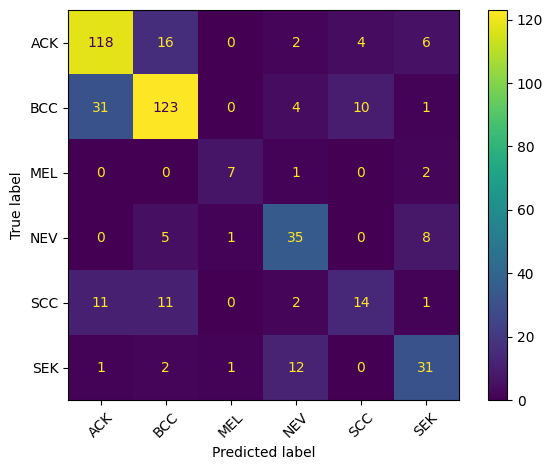

In [ ]:
evaluate_model(student_model, val_loader, class_names, device)

#**Applying learning rate scheduling and focal loss**

In [ ]:
# Focal Loss
class FocalLoss(nn.Module):
    def __init__(self, gamma=2.0, weight=None, reduction='mean'):
        super(FocalLoss, self).__init__()
        self.gamma = gamma
        self.weight = weight
        self.reduction = reduction

    def forward(self, inputs, targets):
        ce_loss = F.cross_entropy(inputs, targets, weight=self.weight, reduction='none')
        pt = torch.exp(-ce_loss)
        focal_loss = ((1 - pt) ** self.gamma) * ce_loss

        if self.reduction == 'mean':
            return focal_loss.mean()
        elif self.reduction == 'sum':
            return focal_loss.sum()
        else:
            return focal_loss

# Distillation Loss with Focal
class DistillationLossWithFocal(nn.Module):
    def __init__(self, temperature=2.0, alpha=0.9, weight=None):
        super(DistillationLossWithFocal, self).__init__()
        self.temperature = temperature
        self.alpha = alpha
        self.kl_div = nn.KLDivLoss(reduction='batchmean')
        self.focal = FocalLoss(weight=weight, gamma=2.0)

    def forward(self, student_logits, teacher_probs, targets):
        T = self.temperature
        soft_loss = self.kl_div(
            F.log_softmax(student_logits / T, dim=1),
            F.softmax(teacher_probs / T, dim=1)
        ) * (T * T)
        hard_loss = self.focal(student_logits, targets)
        return self.alpha * soft_loss + (1 - self.alpha) * hard_loss

# Load the Pretrained Student Model
def load_student_model(path, num_classes, device):
    model = models.densenet121(pretrained=False)
    model.classifier = nn.Linear(model.classifier.in_features, num_classes)
    model.load_state_dict(torch.load(path, map_location=device))
    return model.to(device)

# Training Function
def fine_tune_student_with_focal_and_scheduler(
    student_model, teacher_model,
    train_loader, val_loader,
    device, class_weights_tensor,
    num_epochs=5,
    save_path="/content/drive/MyDrive/Final Year Project/Code/Image Classification/DenseNet121/densenet121_ensembled_focal_sched.pth"
):
    optimizer = torch.optim.AdamW(student_model.parameters(), lr=1e-4, weight_decay=1e-4)
    criterion = DistillationLossWithFocal(temperature=2.0, alpha=0.9, weight=class_weights_tensor)
    scheduler = ReduceLROnPlateau(optimizer, mode='min', patience=2, factor=0.5, verbose=True)

    student_model.to(device)
    teacher_model.to(device)
    teacher_model.eval()

    best_val_acc = 0.0
    history = {"train_loss": [], "train_acc": [], "val_loss": [], "val_acc": []}

    for epoch in range(num_epochs):
        print(f"\\nEpoch {epoch + 1}/{num_epochs}")
        student_model.train()
        running_loss, correct, total = 0.0, 0, 0

        for inputs, labels in tqdm(train_loader, desc="Training", leave=False):
            inputs, labels = inputs.to(device), labels.to(device)
            with torch.no_grad():
                teacher_outputs = teacher_model(inputs)

            optimizer.zero_grad()
            outputs = student_model(inputs)
            loss = criterion(outputs, teacher_outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * inputs.size(0)
            _, predicted = outputs.max(1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)

        train_loss = running_loss / total
        train_acc = correct / total

        # Validation
        student_model.eval()
        val_loss, correct, total = 0.0, 0, 0
        with torch.no_grad():
            for inputs, labels in tqdm(val_loader, desc="Validation", leave=False):
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = student_model(inputs)
                loss = F.cross_entropy(outputs, labels)
                val_loss += loss.item() * inputs.size(0)
                _, predicted = outputs.max(1)
                correct += (predicted == labels).sum().item()
                total += labels.size(0)

        val_loss /= total
        val_acc = correct / total

        scheduler.step(val_loss)

        history["train_loss"].append(train_loss)
        history["train_acc"].append(train_acc)
        history["val_loss"].append(val_loss)
        history["val_acc"].append(val_acc)

        print(f"Train Acc: {train_acc:.4f} | Val Acc: {val_acc:.4f}")

        if val_acc > best_val_acc:
            best_val_acc = val_acc
            torch.save(student_model.state_dict(), save_path)
            print(f"Saved improved model to: {save_path}")

    return history

In [ ]:
class DenseNetEnsemble(nn.Module):
    def __init__(self, path1, path2, num_classes, device):
        super().__init__()
        self.model1 = models.densenet121(weights=None)
        self.model2 = models.densenet121(weights=None)
        self.model1.classifier = nn.Linear(self.model1.classifier.in_features, num_classes)
        self.model2.classifier = nn.Linear(self.model2.classifier.in_features, num_classes)
        self.model1.load_state_dict(torch.load(path1, map_location=device))
        self.model2.load_state_dict(torch.load(path2, map_location=device))
        self.model1.to(device).eval()
        self.model2.to(device).eval()

    def forward(self, x):
        with torch.no_grad():
            p1 = F.softmax(self.model1(x), dim=1)
            p2 = F.softmax(self.model2(x), dim=1)
        return (p1 + p2) / 2

In [ ]:
path3 = "/content/drive/MyDrive/Final Year Project/Code/Image Classification/DenseNet121/densenet121_phase3_block3.pth"
path4 = "/content/drive/MyDrive/Final Year Project/Code/Image Classification/DenseNet121/densenet121_phase4_all.pth"
teacher_model = DenseNetEnsemble(path3, path4, num_classes, device)

In [ ]:
# Load the existing student model
student_model = load_student_model(
    "/content/drive/MyDrive/Final Year Project/Code/Image Classification/DenseNet121/densenet121_ensembled_model_alpha_0_9.pth",
    num_classes=num_classes,
    device=device
)

In [ ]:
# Fine-tune with focal loss and LR scheduling
history = fine_tune_student_with_focal_and_scheduler(
    student_model=student_model,
    teacher_model=teacher_model,
    train_loader=train_loader,
    val_loader=val_loader,
    device=device,
    class_weights_tensor=class_weights_tensor,
    num_epochs=5
)

\nEpoch 1/5


Train Acc: 0.8063 | Val Acc: 0.6761
Saved improved model to: /content/drive/MyDrive/Final Year Project/Code/Image Classification/DenseNet121/densenet121_ensembled_focal_sched.pth
\nEpoch 2/5


Train Acc: 0.8422 | Val Acc: 0.7130
Saved improved model to: /content/drive/MyDrive/Final Year Project/Code/Image Classification/DenseNet121/densenet121_ensembled_focal_sched.pth
\nEpoch 3/5


Train Acc: 0.8406 | Val Acc: 0.6891
\nEpoch 4/5


Train Acc: 0.8711 | Val Acc: 0.7087
\nEpoch 5/5


Train Acc: 0.8738 | Val Acc: 0.7087


Classification Report:
               precision    recall  f1-score   support

         ACK       0.77      0.78      0.78       146
         BCC       0.81      0.65      0.72       169
         MEL       0.89      0.80      0.84        10
         NEV       0.67      0.86      0.75        49
         SCC       0.34      0.51      0.41        39
         SEK       0.68      0.68      0.68        47

    accuracy                           0.71       460
   macro avg       0.69      0.71      0.70       460
weighted avg       0.73      0.71      0.71       460



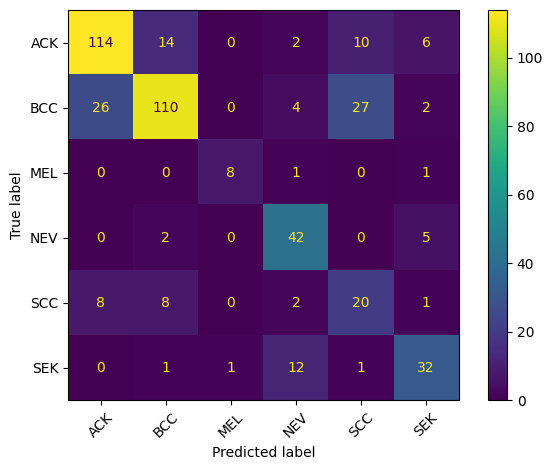

In [ ]:
evaluate_model(student_model, val_loader, class_names, device)